In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Attacking In RISK

In RISK, the goal of the game is to capture all of the territories on the board. A territory is captured by winning an attack. An attack is made up of a sequence of battles, where the attacker and defender roll dice corresponding to the number of armies they have on their respective territories. The rules of RISK dictate a battle is decided as follows:

*"Compare the highest die each of you rolled. If yours (the attackers) is higher, the defender loses one army from the territory under attack. But if the defender's die is higher than yours, you lose one army from the territory you attacked from; put it back in your clear plastic box. If each of you rolled more than one die, now compare the two next-highest dice and repeat the process."*

If the defender runs out of armies before the attacker, the attacker occupies the target territory with his pieces, winning the attack and gaining a RISK card. If the attacker runs out of armies before the defender, the attack phase is over and the attack is lost.

This notebook will analyze battles and attacks, then discuss the results. 
*************
### Battle Probabilities

The first step is to understand the basic probabilities of a battle. A battle can be won, lost, or tied depending on the number of attacking and defending armies, and the rolls of each players dice. These probabilities will be used to analyse the full battle sequence of an attack.

When the defender is rolling a single die, it isn't too difficult to calculate the probability of winning and losing a battle.

Things get a bit more complicated, however, when the defender rolls 2 dice. My approach was to calculate the probability of winning and losing each battle given the defenders 'top' and 'bottom' dice. I'm sure there are better, more general ways to solve this, but this problem was much more difficult than I expected (conditional probability is everywhere...). I also avoided using *max* and *min* operators, as I find they make the formulas less interperatable. If you can find nicer formulas please let me know :).

Against 1 defender the formulas are straightforward as there are no draws.
$$
\mathbb{P}(\text{ win | r attackers vs. 1 defender}) = 1 - \frac{1}{6}\sum_{i=1}^{6}(\frac{i}{6}^{r}) \;\;\;\;\; \mathbb{P}(\text{ lose | r attackers vs. 1 defender}) = \frac{1}{6}\sum_{i=1}^{6}(\frac{i}{6}^{r})
$$

Against 2 defenders the formulas I derived are more complicated, as there is a lot of conditional probability and there are draws. I was unable to derive a general formula that worked for 1 or more attackers, so instead I give seperate eqations for 1 attacker and multiple attackers.

$$
\mathbb{P}(\text{ win | 1 attacker vs. 2 defenders}) = 1 - \sum_{i=1}^{6}(\frac{2i^{2}-i}{6^{3}}) \;\;\;\;\; \mathbb{P}(\text{ lose | 1 attacker vs. 2 defenders}) = \sum_{i=1}^{6}(\frac{2i^{2}-i}{6^{3}})
$$

$$
\mathbb{P}(\text{ win | r>1 attackers vs. 2 defenders}) = \frac{1}{36}\sum_{i=1}^{6}(1-\frac{i^{r}+r(6-i)i^{r-1}}{6^{r}}) + 
                                            \frac{2}{36}\sum_{i=2}^{6}\sum_{j=1}^{i-1}(1-\frac{i^{r}+r(6-i)j^{r-1}}{6^{r}})
$$

$$
\mathbb{P}(\text{ lose | r>1 attackers vs. 2 defenders}) = \frac{1}{36}\sum_{i=1}^{6}(\frac{i}{6}^{r}) + 
                                            \frac{2}{36}\sum_{i=2}^{6}\sum_{j=1}^{i-1}(\frac{j^{r}+r(i-j)j^{r-1}}{6^{r}})
$$

These probabilities work out to:

| $\mathbb{P}$( win *i* vs. *j* ) , $\mathbb{P}$( Lose *i* vs. *j* ) | ***j* = 1 Defenders** | ***j* = 2 Defenders** |
| :---:  | :----: | :----: |
| ***i* = 1 Attackers** |  $15/6^{2}$ , $21/6^{2}$ | $55/6^{3}$ , $161/6^{3}$ | 
| ***i* = 2 Attackers** |  $125/6^{3}$ , $91/6^{3}$ | $295/6^{4}$ , $581/6^{4}$ |
| ***i* = 3 Attackers** |  $855/6^{4}$ , $441/6^{4}$ | $2890/6^{5}$ ,  $2275/6^{5}$|

*Note: For 2 vs 2 and 3 vs 2, the probability that a draw occurs and each player loses an army is 1-P(Win)-P(Loss)*

I verified my findings in two ways. The first, was to make sure that as the number of attacker rolls increased, the probability of winning/losing converged appropriately. When the defender is rolling a single die, P(win) -> 5/6, and when the defender is rolling two dice, P(win) -> 25/36, as the attacker becomes increasingly likely of beating any defender roll not containing a 6. The other way I checked myself was by simulating many battles and recording the results, as seen below. 


In [2]:
wins = 0
draws = 0
trials = 500000
for i in range(trials):
    p1 = np.sort(np.random.randint(6,size=2))
    p2 = np.sort(np.random.randint(6,size=2))
    if p1[-1] > p2[-1] and p1[-2] > p2[-2]:
        wins += 1
    elif p1[-1] > p2[-1] and p1[-2] <= p2[-2]:
        draws += 1
    elif p1[-1] <= p2[-1] and p1[-2] > p2[-2]:
        draws += 1
print(wins/trials)
print(draws/trials)

0.228078
0.324


#### Sample Probabilities:

| % Won , % Drawn , % Lost | ***j* = 1 Defenders** | ***j* = 2 Defenders** |
| :---:  | :----: | :----: |
| ***i* = 1 Attackers** |   0.41689 , n/a , 0.58311  | 0.25398 , n/a , 0.74602 | 
| ***i* = 2 Attackers** |   0.57815 , n/a , 0.42185  | 0.22889 , 0.32417 , 0.44694 |
| ***i* = 3 Attackers** |   0.65882 , n/a , 0.34118  | 0.37188 , 0.33566 , 0.29246 |
    
Note that the sampled probabilities closely agree with our formulas above :)
*******
### Expected Results

The goal of an attack is to effectively eliminate your opponents army. If follows that as the attacker, you may want to maximize the ratio of expected defending armies eliminated to expected attacking armies eliminated. It seems logical that rolling more dice gives you better chances as both attacker and defender, but we can use the probabilities computed above to verify this.

|<ins>_ $\mathbb{E}$(Defending Armies Captured) _</ins> <br /> $\mathbb{E}$(Attacking Armies Captured) | **1 Defender** | **2 Defender** |
| :---:  | :----: | :----: |
| **1 Attacker** |  0.7413 | 0.3416 | 
| **2 Attacker** |  1.3736 | 0.6384 |
| **3 Attacker** |  1.9388 | 1.1718 |
*******
### Attacks
 
Now that we've confirmed the optimal attacking and defending battle strategies, we can use them to predict the outcome of an attack based on the number of attacking and defending armies, assuming optimal play on both ends. This is arguably the most important result of this notebook, as it gives a player insight into the result of an attack, helping them choose when and how best to make offensive plays.

We will consider and compare two strategies: the **win maximizing strategy** and the **army maximizing strategy**. In the **win maximizing strategy**, the goal will be to maximize the probability of winning an attack, which means continuing to battle until either the attacker or his opponent has run out of armies. In the **army maximizing strategy**, the goal will be to maximize the ratio of defending armies captured to attacking armies captured, which means continuing to battle as long as $\mathbb{E}$(*defenders captured / attackers captured*) > 1. **RISK cards**, which are rewarded to the winner of an attack and represent armies, incentivise attacking by giving a bonus to an attacker for winning a battle. This is becomes a factor when trying to maximise armies won to armies lost, as the bonus armies awarded to the winner of an attack bolster this ratio.

Because it is extremely complicated to derive a formula for these probabilities analytically (try it yourself) and the resulting formulas would be much too complicated to be used by any human player, instead we will simulate attack sequences using these strategies and analyse the results. Then we will try to find human-useable formulas that approximate the probability of winning and losing.


In [5]:
battle_prob = [
     [[15/(6**2), 0, 21/(6**2)], [55/(6**3), 0, 161/(6**3)]],
     [[125/(6**3), 0, 91/(6**3)], [295/(6**4), 420/(6**4), 581/(6**4)]],
     [[855/(6**4), 0, 441/(6**4)], [2890/(6**5), 2611/(6**5), 2275/(6**5)]]]

attackers = 25
defenders = 25
trials = 10000
s2_outcomes = [[[] for _ in range(defenders)] for _ in range(attackers)]

def simulate(a0, d0, trials, outcomes, battle_prob):
    # base cases 
    #if (a0==0) or (d0==0): # win maximizing strategy
    if (d0==0) or (a0<=1) or (a0==2 and d0==2): # army maximizing strategy
        return [a0,d0]
    if len(outcomes[a0][d0]) == trials:
        i = np.random.randint(trials)
        return(outcomes[a0][d0][i])
        
    # transition
    p = battle_prob[min(2,a0-1)][min(1,d0-1)]
    s = np.random.random_sample()
    if p[0]>s: # win battle
        a = a0
        d = d0 - min(2,d0)
    elif (p[0]+p[1])>s: # draw battle
        a = a0 - 1
        d = d0 - 1
    else: # lose battle
        a = a0 - min(2,a0)
        d = d0
    
    # recursive step
    outcome = simulate(a, d, trials, outcomes, battle_prob)
    outcomes[a0][d0].append(outcome)
    return outcome

for a0 in range(attackers):
    for d0 in range(defenders):
        for _ in range(trials - len(s2_outcomes[a0][d0])):
            simulate(a0, d0, trials, s2_outcomes, battle_prob)

Now that we've simulated and recorded many attacks, we will extract meaningful statistics.

In [6]:
# get win percentage from a row of outcomes
def wp(x):
    if len(x)==0:
        return 0
    wins = 0
    for pt in x:
        if pt[1]==0:
            wins += 1
    return wins/len(x)

# get armies won / armies lost from a row or outcomes
def ex(x,i,j,bonus=0.333):
    if len(x)==0:
        return 1
    b = 0
    for pt in x:
        if pt[1]==0:
            b += bonus
    s = (-np.array(x)+np.array([i,j])).sum(axis=0)
    return (s[1]+b)/s[0]

s1_win_percentage = np.array([[wp(x) for x in y] for y in s1_outcomes])
s2_win_percentage = np.array([[wp(x) for x in y] for y in s2_outcomes])

s1_army_ratio = np.array([[ex(s1_outcomes[i][j],i,j) for j in range(defenders)] for i in range(attackers)])
s2_army_ratio = np.array([[ex(s2_outcomes[i][j],i,j) for j in range(defenders)] for i in range(attackers)])
s1_army_ratio_bonus = np.array([[ex(s1_outcomes[i][j],i,j,4/3) for j in range(defenders)] for i in range(attackers)])

Visualize the results of our simulation

<AxesSubplot:>

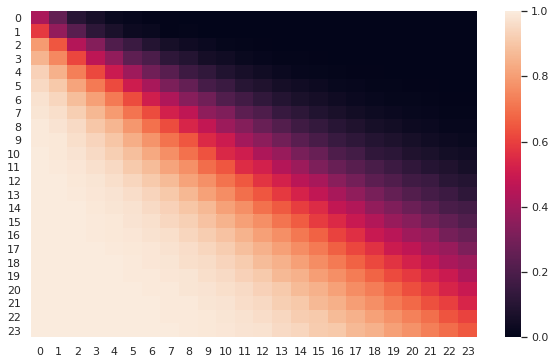

In [8]:
# Draw a heatmap with the numeric values in each cell
sns.set_theme()
df = pd.DataFrame(s1_win_percentage[1:,1:])
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df, annot=False, linewidths=0, ax=ax, cbar=True)

plot the likeliehood of winning vs attackers and defenders

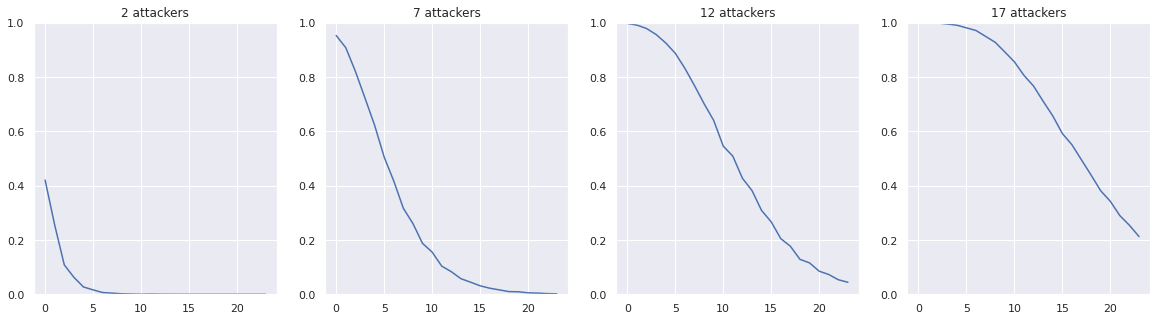

In [9]:
f, axs = plt.subplots(1,4,figsize=(20, 5))
for i in range(4):
    axs[i].set_ylim([0, 1])
    axs[i].set_title(str(2+5*i)+' attackers')
    axs[i].plot(s1_win_percentage[1+5*i][1:])
plt.show()

Plot the difference in win percentage of the two strategies

<AxesSubplot:>

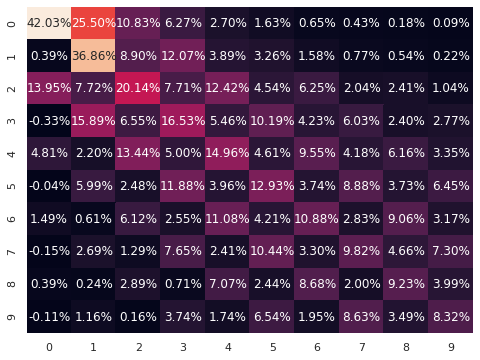

In [10]:
# Draw a heatmap with the numeric values in each cell
sns.set_theme()
df = pd.DataFrame((s1_win_percentage-s2_win_percentage)[1:11,1:11])
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt='.2%', linewidths=0, ax=ax, cbar=False)

Plot the difference in *armies captured / armies lost* with and without risk card bonus.

<AxesSubplot:>

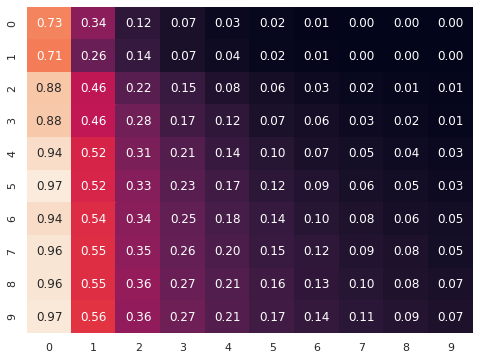

In [11]:
# Draw a heatmap with the numeric values in each cell
sns.set_theme()
df = pd.DataFrame((s1_army_ratio_bonus-s1_army_ratio)[1:11,1:11])
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt='.2f', linewidths=0, ax=ax, cbar=False)

visualise *armies captured / armies lost*

<AxesSubplot:>

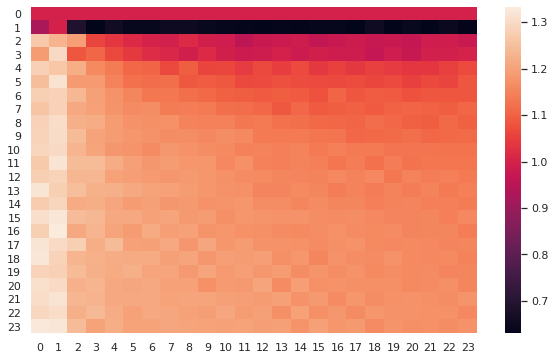

In [12]:
# Draw a heatmap with the numeric values in each cell
sns.set_theme()
df = pd.DataFrame(s2_army_ratio[1:,1:])
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df, annot=False, linewidths=0, ax=ax, cbar=True)

#### Insights:

1. The 50% win line down the main diagonal of the first plot seems to suggest that a simple linear seperator may tell us if we are more likely to win or lose. A linear function could therefore yield a very simple formula that a player could use in a game to tell him if he is more likely to win or not. 

2. The 'regularity' seen in the second plot suggests a low degree polynomial $F:\mathbb{R}^{2}\rightarrow\mathbb{R}$ may be able to approximate win percentage. Using polynomial regression may yield a low degree polynomial approximation of win percentage that could be used by a player in a game, but this seems somewhat unlikely as the plots don't look like polynomials. The plots do, however, look like sigmoid functions - so maybe logistic regression could yield very good estimates.

3. One interesting observation is in the way that *graph* is traversed, which created a sort of tiling pattern on the third plot. For the majority of battle situations, two armies are always removed. This means if the sum of your and your opponents dice will remain odd or even for a majority of the attack sequence. For example, if yours and your opponents dice add to 17 before a battle, you will never end in a 2v2 situation. 

4. A suprising result, for me, was how agressive the **army maximizing strategy** was. This is highlighted in the fifth plot. The outcome does not matter - so long as more than ~6 attackers are used, probability has it that the attacker will capture more pieces than they will lose.

5. The RISK card incentives don't change general attack strategy much (plot 4), as they don't change the 50% win mark. Incentives do, however, change the **army maximizing strategy** into the **win maximizing strategy** at the base *edge* cases of our graph. For example, with an incentive > 1/3 per risk card, you maximize armies and wins by attacking in a 1v1. With an incentive > 1 per risk card, you maximize armies and wins by attacking in a 1v2. With an incentive > 4/3 per risk card, you maximize armies and wins by attacking in a 2v2. *Note: This is only true for the first attack if your turn, as you can only earn one RISK card per turn.*
*********
### Models

Based on my above observations, I have decided to try and construct two models. One will tell how many troops are needed to win an attack > 50% of the time. This model will be simple and very easy to use. The other will approximate win percentage using number of attackers and defenders. This model will probably be slightly clunkier and harder to remember, but will give more insight than its more simple counterpart.

Linear Regression:

In [13]:
from sklearn.linear_model import Ridge

mask = (np.abs(s1_win_percentage-0.5)<0.05)
X = []
y = []
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i,j]:
            X.append([i])
            y.append(j)
            
model = Ridge().fit(X, y)
print(model.score(X,y))
print(model.coef_, model.intercept_)

0.9927922216086875
[1.17510644] -0.9756107643338527


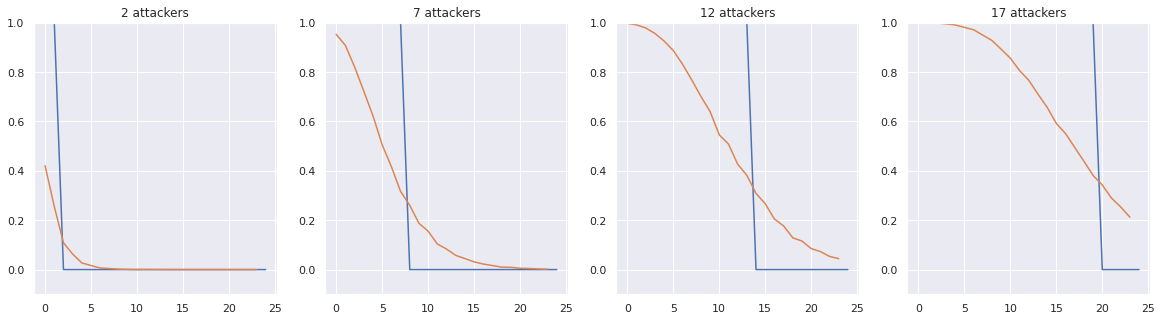

In [14]:
f, axs = plt.subplots(1,4,figsize=(20, 5))
for i in range(4):
    pred = model.predict([[2+5*i]])
    axs[i].plot([int(i<pred) for i in range(25)])
    axs[i].set_ylim([-.1, 1])
    axs[i].set_title(str(2+5*i)+' attackers')
    axs[i].plot(s1_win_percentage[1+5*i][1:])
plt.show()

Logistic Regression (binary):

In [15]:
from sklearn.linear_model import LogisticRegression

X = np.array([[[i,j] for j in range(s1_win_percentage.shape[1])] for i in range(s1_win_percentage.shape[0])]).reshape((s1_win_percentage.size,2))
y = (s1_win_percentage>0.50).flatten().astype(float)

clf = LogisticRegression().fit(X, y)
print('MSE:',np.linalg.norm(clf.predict_proba(X)[:,1]-s1_win_percentage.flatten()))
print(clf.coef_, clf.intercept_)

MSE: 4.7698191891959025
[[ 0.38497882 -0.25466652]] [-1.53926806]


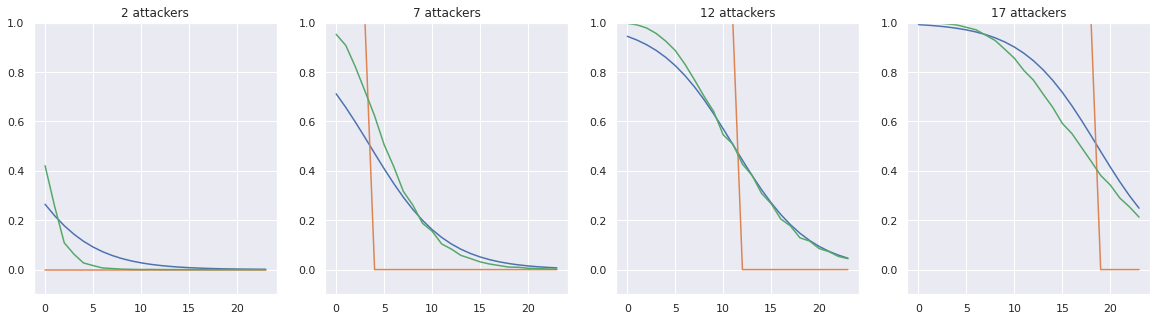

In [16]:
f, axs = plt.subplots(1,4,figsize=(20, 5))
for i in range(4):
    x = [[2+5*i,j] for j in range(1,25)]
    axs[i].plot(clf.predict_proba(x)[:,1])
    axs[i].plot(clf.predict(x))
    axs[i].set_ylim([-.1, 1])
    axs[i].set_title(str(2+5*i)+' attackers')
    axs[i].plot(s1_win_percentage[1+5*i][1:])
plt.show()

Polynomial Regression:

In [17]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.array([[[i,j] for j in range(s1_win_percentage.shape[1])] for i in range(s1_win_percentage.shape[0])]).reshape((s1_win_percentage.size,2))
y = s1_win_percentage.flatten()

model = make_pipeline(PolynomialFeatures(4), Ridge())
model.fit(X, y)
print('MSE:',np.linalg.norm(model.predict(X)-s1_win_percentage.flatten()))
#print('Pow:', model[0].powers_, '\n Coef:',model[1].coef_,'\n Bias:',model[1].intercept_)

MSE: 3.278751442875116


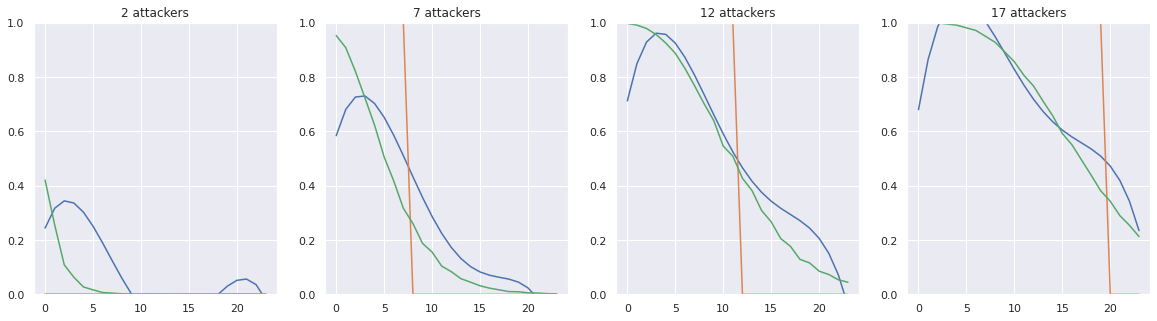

In [18]:
f, axs = plt.subplots(1,4,figsize=(20, 5))
for i in range(4):
    x = [[2+5*i,j] for j in range(1,25)]
    pred = model.predict(x)
    axs[i].plot(pred)
    axs[i].plot((pred>0.5).astype(int))
    axs[i].set_ylim([0, 1])
    axs[i].set_title(str(2+5*i)+' attackers')
    axs[i].plot(s1_win_percentage[1+5*i][1:])
plt.show()

Logistic regression (continuous):

In [19]:
X = np.array([[[i,j] for j in range(s1_win_percentage.shape[1])] for i in range(s1_win_percentage.shape[0])]).reshape((s1_win_percentage.size,2))
y = (s1_win_percentage*0.98+0.01).flatten() # to remove 1s and zeros
y_trans = np.log((1 / y) - 1)

model = Ridge().fit(X, y_trans)
print('MSE:',np.linalg.norm((1 / (1 + np.exp(model.predict(X))))-s1_win_percentage.flatten()))
print(model.coef_, model.intercept_)

MSE: 4.928125135689324
[-0.30380286  0.17933909] 1.6743869243257299


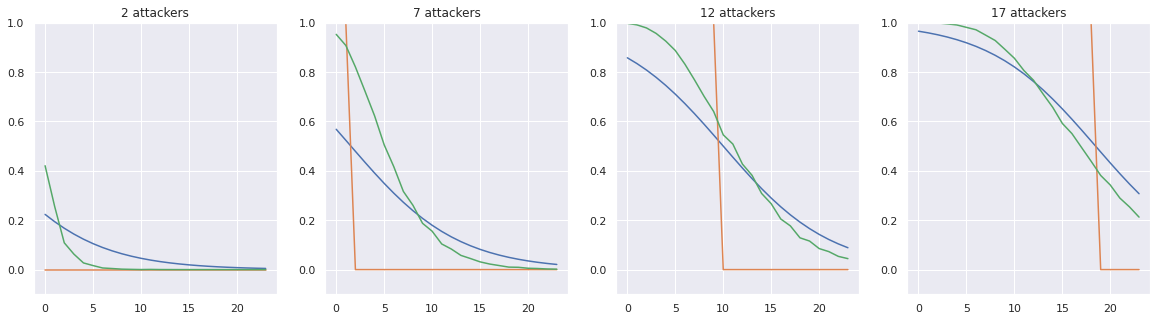

In [20]:
f, axs = plt.subplots(1,4,figsize=(20, 5))
for i in range(4):
    x = [[2+5*i,j] for j in range(1,25)]
    pred = 1 / (1 + np.exp(model.predict(x)))
    axs[i].plot(pred)
    axs[i].plot((pred>0.5).astype(int))
    axs[i].set_ylim([-.1, 1])
    axs[i].set_title(str(2+5*i)+' attackers')
    axs[i].plot(s1_win_percentage[1+5*i][1:])
plt.show()

After experimenting with linear regression, logistic regression (binary and continuous), and polynomial regression - my opinion is that binary **logistic regression gives the best model** for several reasons. First is performance. The binary logistic regression model was outperformed only by polynomial regression, and this brings me to my second point. The logistic model is versatile and easy to use, requiring only that a player remembers 3 variables. In order for the polynomial model to outperform the logistic models, it had to do a transformation of degree 3. This means if a player wanted to use this model they would need to remember over 40 variables!

All a player needs to remember is the following linear function:

$$
F(x = \text{attackers},\;y=\text{defenders}) = 0.38x-0.26y-1.54
$$

The nice thing about this is it is easy to remember and can be used two ways. The simple way is a player can solve ***F(x,y|x or y)=0*** to approximate the minimum number of attackers or defenders they need to win 50% of the time. The other way to use this is to plug it into the logistic function, which gives win percentage as a function of attackers and defenders as seen below. From here, you can solve for win percentage, attackers needed, or defenders needed in an attack. These are more difficult calculations though, and may require a calculator.
$$
G(x = \text{attackers},\;y=\text{defenders}) = \frac{1}{1-e^{F(x,y)}}
$$

******
### Concluding thoughts

In this notebook, we got a feeling for how battles worked by analysing the probabilities of their outcomes. This verified some ideas about attacks and provided insight on the outcomes of important game situations. Next, we simulated many complete attacks and analysed the results. This answered questions like *when is a player more likely to win in an attack?* and *when should a player risk losing an attack for the chance to gain a risk card?* (The inquisitive reader may have noticed that we did not come to a verdict on if attacking for the sole sake of increasing the relative size of your army is a good idea or not, as in the 7 vs 25 case. We will revisit this in later chapters, as it is more a question of strategy than probability and depends on many other factors.) Finally, we used all this information to find a useable formula to help inform a player on how attacks will play out.

I think this notebook was a good intro to RISK battles, shedding light on useful attack information and giving a taste for some strategy to come. 